# discrete_tf - Pythonize

Use Python's syntactic sugar to 'pythonize' the Simulink Model. This class wraps the Simulink Model with some Python concepts. In addition to wrapping all of the functions with Python, it builds in a data-logger and plotting.

![](discrete_tf.png)

# Python Setup

In [1]:
from discretetf import DiscreteTF

In [2]:
mdl = DiscreteTF()

In [3]:
mdl.initialize()
mdl

discrete_tf<0.0, 0.0, 0.0>

In [4]:
mdl.step()
mdl

discrete_tf<0.0, 0.0, 0.0>

In [5]:
mdl.step()
mdl

discrete_tf<0.001, 0.0, 0.0>

In [6]:
mdl.step()
mdl

discrete_tf<0.002, 0.0, 0.0>

In [7]:
mdl.num

[0.0, 0.0014996250624921886]

In [8]:
mdl.den

[1.0, -0.9995001249791693]

# Validate against `control` toolbox.

In [9]:
import control
import numpy as np

In [10]:
# How fast the simulink model is running.
Ts=1e-3
# Static Gain
K = 3
# Time Constant.
tau = 2
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.00149963]), array([ 1.        , -0.99950012]), 0.001)

In [11]:
sysd.num

[[array([0.00149963])]]

In [12]:
mdl.num

[0.0, 0.0014996250624921886]

In [13]:
np.isclose(sysd.num, mdl.num)

array([[[False,  True]]])

In [14]:
sysd.den

[[array([ 1.        , -0.99950012])]]

In [15]:
mdl.den

[1.0, -0.9995001249791693]

In [16]:
np.isclose(sysd.den, mdl.den)

array([[[ True,  True]]])

# Pythonic Interactions

In [17]:
mdl.initialize()
for step in range(int(15/Ts)+1):
    mdl.step()
mdl.time

15.0

In [18]:
mdl.step_num

15000

## Using the Datalogger

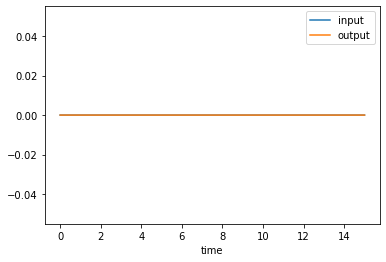

In [21]:
data = dict()
mdl.init_log()
for step in range(int(15/Ts)+1):
    mdl.step_log()
mdl.plot()

# Step Response

*Sample homework problem?*

- Plot step response for a first order system with $\tau=1s,2s,3s$ for K=1. Make the step at 2s.
- The model is compiled with K=3, $\tau=2s$
- The simulink model is running at 0.001s.

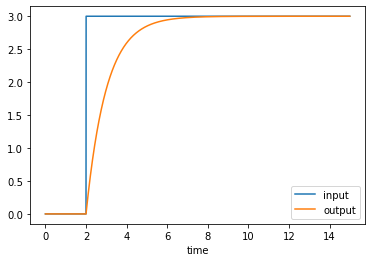

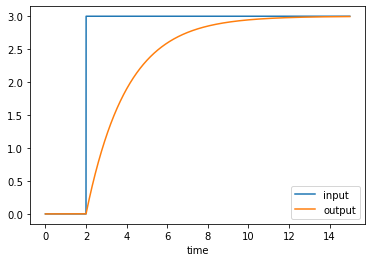

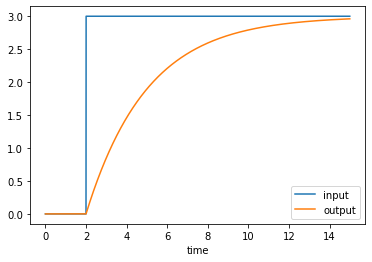

In [22]:
dt=0.001
K = 1
dataframes = list()
for tau in [1, 2, 3]:
    sys = control.TransferFunction([K], [tau, 1])
    sysd = control.c2d(sys, Ts)
    mdl.num = sysd.num[0][0]
    mdl.den = sysd.den[0][0]
    mdl.init_log()
    for step in range(int(15/Ts)):
        mdl.input_signal = 3 if mdl.time>=2 else 0
        mdl.step_log()
    mdl.plot()
    dataframes.append(mdl.dataframe)

In [34]:
dataframes[0].rename(columns={"output": "output_tau1"}, inplace=True)
dataframes[1].rename(columns={"output": "output_tau2"}, inplace=True)
dataframes[2].rename(columns={"output": "output_tau3"}, inplace=True)

In [38]:
df = dataframes[0].append(dataframes[1]).append(dataframes[2])

<AxesSubplot:xlabel='time'>

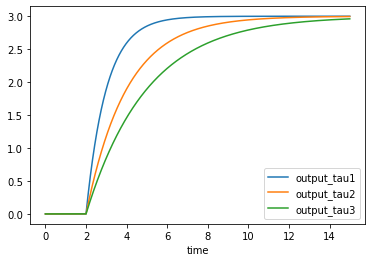

In [39]:
df.plot(x='time', y=["output_tau1", "output_tau2", "output_tau3"])

# Sine Response

*Sample homework problem?*

- Input a sine-wave to the system. Estimate the mag/phase and compare to the ```control.bode``` function.
- The simulink model is running at 0.001s.

In [154]:
import random

In [155]:
# "Black box"
K = random.randint(1, 10)
tau = random.randint(1, 10)
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
mdl.num = sysd.num[0][0]
mdl.den = sysd.den[0][0]

### Solution

In [158]:
def input_fcn(step, freq):
    """Function to simplify calculate sine response given step and frequency (hz)."""
    return np.sin(2*np.pi*freq*step/1000)

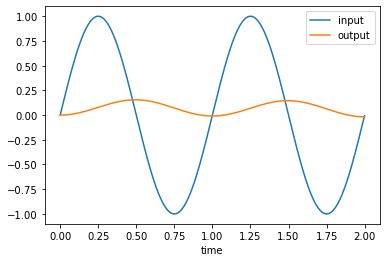

In [159]:
mdl.init_log()
for step in range(int(2/Ts)):
    mdl.input_signal = input_fcn(step, 1)
    mdl.step_log()
mdl.plot()
dataframes.append(mdl.dataframe)

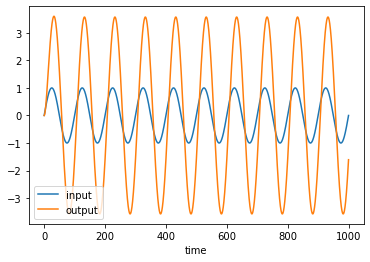

In [164]:
f=0.01
mdl.init_log()
for step in range(int((10*1/f)/Ts)):
    mdl.input_signal = input_fcn(step, f)
    mdl.step_log()
mdl.plot()

In [165]:
df=mdl.dataframe[int(1000000/2):]

In [166]:
df.input.max()

1.0

In [167]:
df.output.max()

3.5739054743516614

In [171]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error 

In [183]:
def minfunc(*args):
    """Function to calculate error between estimate and output."""
    A=args[0][0]
    phi=args[0][1]
    output_p = A*np.sin(2*np.pi*f*df.time+phi)
    return mean_squared_error(output_p, df.output)

x0=[8.7, -np.pi/4]
results = minimize(minfunc, x0)
results

      fun: 3.220962987475189e-16
 hess_inv: array([[ 9.99996524e-01, -1.25928081e-05],
       [-1.25928081e-05,  7.82329159e-02]])
      jac: array([1.40818821e-10, 8.29902406e-09])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([ 3.57390547, -0.46580064])

In [174]:
control.bode(sysd, omega=[2*np.pi*f], plot=False)

(array([3.57390548]), array([-0.46580063]), array([0.06283185]))

In [186]:
data = list()
for f in np.logspace(-2, 3):
    mdl.init_log()
    for step in range(int((10*1/f)/Ts)):
        mdl.input_signal = input_fcn(step, f)
        mdl.step_log()
        
    def minfunc(*args):
        """Function to calculate error between estimate and output."""
        A=args[0][0]
        phi=args[0][1]
        output_p = A*np.sin(2*np.pi*f*df.time+phi)
        return mean_squared_error(output_p, df.output)
    results = minimize(minfunc, [1, -1])
    data.append({
        "f": f,
        "mag": results['x'][0],
        "phase": results['x'][1]
    })

In [189]:
import pandas as pd

In [190]:
df = pd.DataFrame(data)

In [191]:
df

,f,mag,phase
0,0.010000,3.573906e+00,-0.465801
1,0.012649,-6.908760e-01,-0.460831
2,0.015999,-7.025614e-04,-1.000320
3,0.020236,6.784974e-02,-1.894898
4,0.025595,7.106145e-02,-2.157014
5,0.032375,-4.528138e-02,0.364886
6,0.040949,-5.876854e-02,-2.448231
7,0.051795,-1.395238e-02,-0.240674
8,0.065513,2.321648e-02,-2.124116
9,0.082864,-2.512560e-02,-2.265648
